# MNIST convolutional neural networks with slim

* MNIST data를 가지고 softmax classifier를 만들어보자.
  * [소스: mnist_softmax.py in verion 1.4](https://github.com/tensorflow/tensorflow/blob/r1.4/tensorflow/examples/tutorials/mnist/mnist_softmax.py)
  * 네트워크 구조는 `03.cnn/01.1_.mnist.deep.with.estimator.ipynb` 에서 가져옴
  * [`tf.contrib.slim` 참고](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/contrib/slim)

### Import modules

In [1]:
"""A very simple MNIST classifier.
See extensive documentation at
https://www.tensorflow.org/get_started/mnist/beginners in version 1.4
"""
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

import tensorflow as tf

slim = tf.contrib.slim

sess_config = tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True))

### Import data

In [2]:
# Load training and eval data from tf.keras
(train_data, train_labels), (test_data, test_labels) = \
    tf.keras.datasets.mnist.load_data()

train_data = train_data / 255.
train_labels = np.asarray(train_labels, dtype=np.int32)

test_data = test_data / 255.
test_labels = np.asarray(test_labels, dtype=np.int32)

### Show the MNIST

label = 0


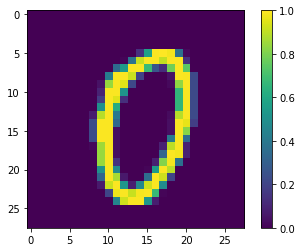

In [3]:
index = 1000
print("label = {}".format(train_labels[index]))
plt.imshow(train_data[index])
plt.colorbar()
#plt.gca().grid(False)
plt.show()

### Set up dataset with `tf.data`

#### create input pipeline with `tf.data.Dataset`

In [4]:
tf.set_random_seed(219)
batch_size = 32
max_epochs = 1

# for train
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels))
train_dataset = train_dataset.shuffle(buffer_size = 10000)
train_dataset = train_dataset.repeat(count = max_epochs)
train_dataset = train_dataset.batch(batch_size = batch_size)
print(train_dataset)

# for test
test_dataset = tf.data.Dataset.from_tensor_slices((test_data, test_labels))
test_dataset = test_dataset.batch(batch_size = len(test_data))
print(test_dataset)

<BatchDataset shapes: ((?, 28, 28), (?,)), types: (tf.float64, tf.int32)>
<BatchDataset shapes: ((?, 28, 28), (?,)), types: (tf.float64, tf.int32)>


#### Define Iterator

In [5]:
# tf.data.Iterator.from_string_handle의 output_shapes는 default = None이지만 꼭 값을 넣는 게 좋음
handle = tf.placeholder(tf.string, shape=[])
iterator = tf.data.Iterator.from_string_handle(handle,
                                               train_dataset.output_types,
                                               train_dataset.output_shapes)
x, y = iterator.get_next()
x = tf.cast(x, dtype = tf.float32)
y = tf.cast(y, dtype = tf.int32)

## `tf.contrib.slim`

```python
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

# pylint: disable=unused-import,line-too-long,g-importing-member,wildcard-import
# TODO(jart): Delete non-slim imports
from tensorflow.contrib import losses
from tensorflow.contrib import metrics
from tensorflow.contrib.framework.python.ops.arg_scope import *
from tensorflow.contrib.framework.python.ops.variables import *
from tensorflow.contrib.layers.python.layers import *
from tensorflow.contrib.layers.python.layers.initializers import *
from tensorflow.contrib.layers.python.layers.regularizers import *
from tensorflow.contrib.slim.python.slim import evaluation
from tensorflow.contrib.slim.python.slim import learning
from tensorflow.contrib.slim.python.slim import model_analyzer
from tensorflow.contrib.slim.python.slim import queues
from tensorflow.contrib.slim.python.slim import summaries
from tensorflow.contrib.slim.python.slim.data import data_decoder
from tensorflow.contrib.slim.python.slim.data import data_provider
from tensorflow.contrib.slim.python.slim.data import dataset
from tensorflow.contrib.slim.python.slim.data import dataset_data_provider
from tensorflow.contrib.slim.python.slim.data import parallel_reader
from tensorflow.contrib.slim.python.slim.data import prefetch_queue
from tensorflow.contrib.slim.python.slim.data import tfexample_decoder
from tensorflow.python.util.all_util import make_all
# pylint: enable=unused-import,line-too-long,g-importing-member,wildcard-import

__all__ = make_all(__name__)
```

### Difference between [`tf.layers`](https://www.tensorflow.org/api_docs/python/tf/layers) and [`tf.contrib.layers`](https://www.tensorflow.org/api_docs/python/tf/contrib/layers)

#### [`tf.layers.conv2d()`](https://www.tensorflow.org/api_docs/python/tf/layers/conv2d)
```python
tf.layers.conv2d(
    inputs,
    filters,
    kernel_size,
    strides=(1, 1),
    padding='valid',
    data_format='channels_last',
    dilation_rate=(1, 1),
    activation=None,
    use_bias=True,
    kernel_initializer=None,
    bias_initializer=tf.zeros_initializer(),
    kernel_regularizer=None,
    bias_regularizer=None,
    activity_regularizer=None,
    kernel_constraint=None,
    bias_constraint=None,
    trainable=True,
    name=None,
    reuse=None
)
```

#### [`slim.conv2d()`](https://www.tensorflow.org/api_docs/python/tf/contrib/layers/conv2d)
```python
tf.contrib.layers.conv2d(
    inputs,
    num_outputs,
    kernel_size,
    stride=1,
    padding='SAME',
    data_format=None,
    rate=1,
    activation_fn=tf.nn.relu,
    normalizer_fn=None,
    normalizer_params=None,
    weights_initializer=initializers.xavier_initializer(),
    weights_regularizer=None,
    biases_initializer=tf.zeros_initializer(),
    biases_regularizer=None,
    reuse=None,
    variables_collections=None,
    outputs_collections=None,
    trainable=True,
    scope=None
)
```

### Create the model

In [6]:
def cnn_model_fn(x):
  """Model function for CNN.
  Args:
    x: input images
    mode: boolean whether trainig mode or test mode
    
  Returns:
    logits: unnormalized score funtion
  """
  # Input Layer
  # Reshape X to 4-D tensor: [batch_size, width, height, channels]
  # MNIST images are 28x28 pixels, and have one color channel
  with tf.name_scope('reshape'):
    x_image = tf.reshape(x, [-1, 28, 28, 1])

  # Convolutional Layer #1
  # Input Tensor Shape: [batch_size, 28, 28, 1]
  # Output Tensor Shape: [batch_size, 28, 28, 32]
  conv1 = slim.conv2d(x_image, 32, [5, 5], scope='conv1')
  #conv1 = tf.layers.conv2d(
  #    inputs=x_image,
  #    filters=32,
  #    kernel_size=[5, 5],
  #    padding="same",
  #    activation=tf.nn.relu)

  # Pooling Layer #1
  # Input Tensor Shape: [batch_size, 28, 28, 32]
  # Output Tensor Shape: [batch_size, 14, 14, 32]
  pool1 = slim.max_pool2d(conv1, [2, 2], scope='pool1')
  #pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)
  
  # Convolutional Layer #2
  # Input Tensor Shape: [batch_size, 14, 14, 32]
  # Output Tensor Shape: [batch_size, 14, 14, 64]
  conv2 = slim.conv2d(pool1, 64, [5, 5], scope='conv2')

  # Pooling Layer #2
  # Second max pooling layer with a 2x2 filter and stride of 2
  # Input Tensor Shape: [batch_size, 14, 14, 64]
  # Output Tensor Shape: [batch_size, 7, 7, 64]
  pool2 = slim.max_pool2d(conv2, [2, 2], scope='pool2')

  # Flatten tensor into a batch of vectors
  # Input Tensor Shape: [batch_size, 7, 7, 64]
  # Output Tensor Shape: [batch_size, 7 * 7 * 64]
  pool2_flat = slim.flatten(pool2, scope='flatten')
  
  # Fully connected Layer
  # Input Tensor Shape: [batch_size, 7 * 7 * 64]
  # Output Tensor Shape: [batch_size, 1024]
  fc1 = slim.fully_connected(pool2_flat, 1024, scope='fc1')
  #dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)

  # Add dropout operation; 0.6 probability that element will be kept
  is_training = tf.placeholder(tf.bool)
  fc1_drop = slim.dropout(fc1, keep_prob=0.6, is_training=is_training, scope='dropout')
  #dropout = tf.layers.dropout(inputs=dense, rate=0.4, training=is_training)

  # Logits layer
  # Input Tensor Shape: [batch_size, 1024]
  # Output Tensor Shape: [batch_size, 10]
  logits = slim.fully_connected(fc1_drop, 10, activation_fn=None, scope='logits')
  
  return logits, is_training, x_image

### Build the model

In [7]:
logits, is_training, x_image = cnn_model_fn(x)

### Define loss and optimizer

In [8]:
cross_entropy = tf.losses.sparse_softmax_cross_entropy(labels=y, logits=logits)

train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

### Assign `tf.summary.FileWriter`

In [9]:
graph_location = 'graphs/02.mnist.deep.slim'
print('Saving graph to: %s' % graph_location)
train_writer = tf.summary.FileWriter(graph_location)
train_writer.add_graph(tf.get_default_graph()) 

Saving graph to: graphs/02.mnist.deep.slim


### `tf.summary`

In [10]:
with tf.name_scope('summaries'):
  tf.summary.scalar('loss/cross_entropy', cross_entropy)
  tf.summary.image('images', x_image)
  for var in tf.trainable_variables():
    tf.summary.histogram(var.op.name, var)
  # merge all summaries
  summary_op = tf.summary.merge_all()

### `tf.Session()` and train

In [11]:
sess = tf.Session(config=sess_config)
sess.run(tf.global_variables_initializer())

# train_iterator
train_iterator = train_dataset.make_one_shot_iterator()
train_handle = sess.run(train_iterator.string_handle())

# Train
step = 1
while True:
  try:
    start_time = time.time()
    _, loss = sess.run([train_step, cross_entropy],
                       feed_dict={handle: train_handle,
                                  is_training: True})
    if step % 10 == 0:
      clear_output(wait=True)
      duration = time.time() - start_time
      examples_per_sec = batch_size / float(duration)
      epochs = batch_size * step / float(len(train_data))
      print("epochs: {:.2f}, step: {}, loss: {:g}, ({:.2f} examples/sec; {:.3f} sec/batch)".format(epochs, step, loss, examples_per_sec, duration))

    if step % 200 == 0:
      # summary
      summary_str = sess.run(summary_op, feed_dict={handle: train_handle, is_training: False})
      train_writer.add_summary(summary_str, global_step=step)

    step += 1

    #if step > 100:
    #  break

  except tf.errors.OutOfRangeError:
    print("End of dataset")  # ==> "End of dataset"
    break

train_writer.close()
print("training done!")

epochs: 0.99, step: 1860, loss: 0.0578385, (381.25 examples/sec; 0.084 sec/batch)
End of dataset
training done!


### Test trained model

* test accuracy: 0.9785 for 1 epoch

In [12]:
# test_iterator
test_iterator = test_dataset.make_one_shot_iterator()
test_handle = sess.run(test_iterator.string_handle())

### Use `tf.metrics`

In [13]:
accuracy, acc_op = tf.metrics.accuracy(labels=y, predictions=tf.argmax(logits, 1), name='accuracy')
sess.run(tf.local_variables_initializer())

sess.run(acc_op, feed_dict={handle: test_handle, is_training: False})
print("test accuracy:", sess.run(accuracy))

test accuracy: 0.9785


### Plot test set

In [14]:
np.random.seed(219)

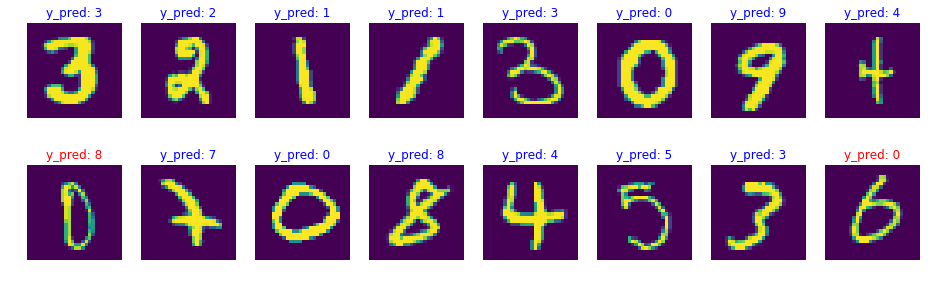

In [15]:
test_batch_size = 16
batch_index = np.random.choice(len(test_data), size=test_batch_size, replace=False)

batch_xs = test_data[batch_index]
batch_ys = test_labels[batch_index]
y_pred = sess.run(logits, feed_dict={x: batch_xs, is_training: False})

fig = plt.figure(figsize=(16, 10))
for i, (px, py) in enumerate(zip(batch_xs, y_pred)):
  p = fig.add_subplot(4, 8, i+1)
  if np.argmax(py) == batch_ys[i]:
    p.set_title("y_pred: {}".format(np.argmax(py)), color='blue')
  else:
    p.set_title("y_pred: {}".format(np.argmax(py)), color='red')
  #p.imshow(px.reshape(28, 28), cmap='gray')
  p.imshow(px.reshape(28, 28))
  p.axis('off')

## 직접 실습

* 여러가지 hyper-parameter들을 바꿔가면서 accuracy를 높혀보자